In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from model import BuildingSimulation as bs, BuildingGraph as bg
from model.utils import *
import matplotlib.colors as mcolors


plt.close('all')

## Load P4 Data

Text(0.5, 1.0, 'Outdoor temperature')

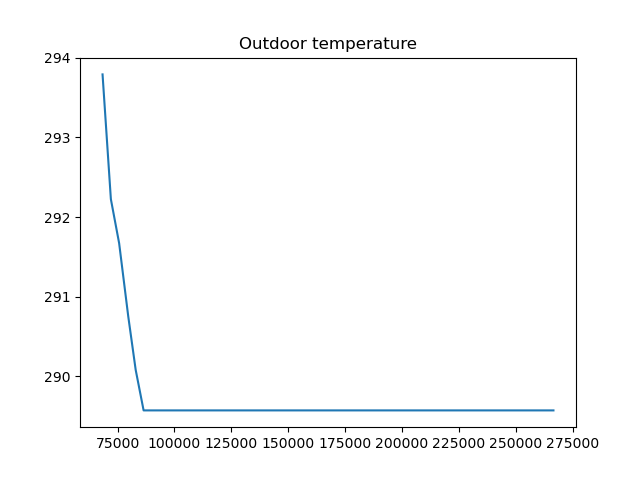

In [2]:
# Window dimmensions
H = 1
W = 1

# Load data
JW = sp.io.loadmat('JulyWeek.mat')
alphas = [42, 42, 42]
As = [1.61, 1.755, 1.755]
Ls = [11.34, 6.62, 2.07]

Q4 = sp.io.loadmat('./Q4data.mat')

Real_Tint = Q4['TintMeas'].flatten() + 273.15

T_start = Real_Tint[0]

hours = Q4['time'].flatten()
times = hours * 60 * 60
Touts = Q4['Tout'].flatten() + 273.15

N = len(times)
repeatcount = 10 * N

Touts = np.concatenate([Touts, np.tile(Touts[-1], repeatcount)])
dt = times[1] - times[0]
times = np.concatenate([times, times[-1] + np.arange(1, repeatcount + 1) * dt])

plt.figure()
plt.plot(times, Touts)
plt.title('Outdoor temperature')

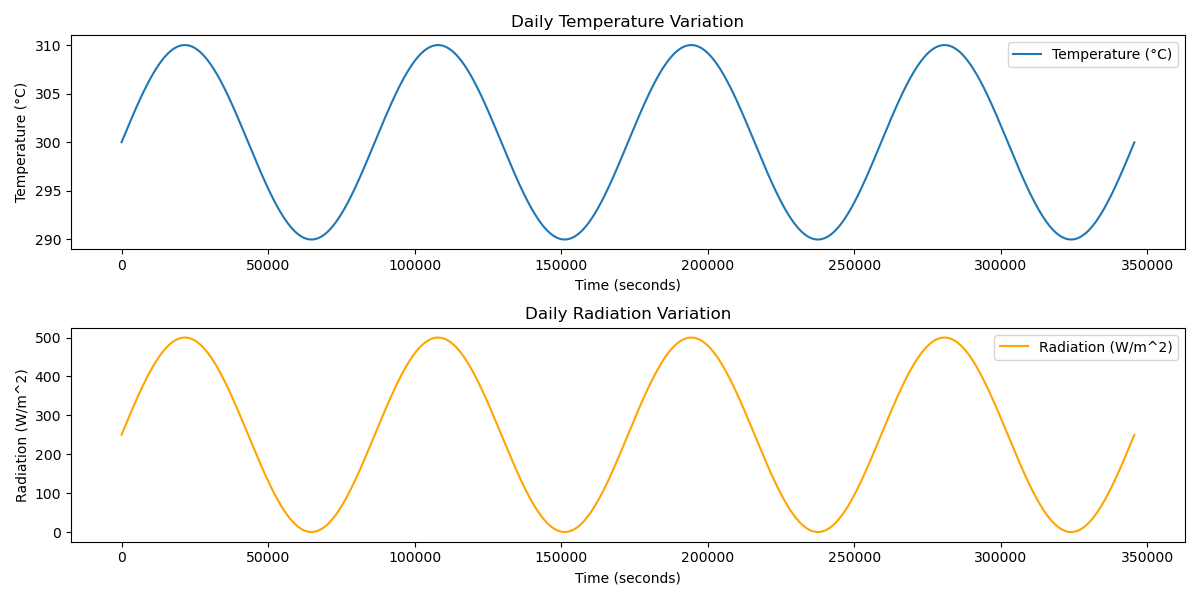

In [3]:
# Function to generate sinusoidal data for temperature and radiation
def generate_sinusoidal_data(delt = 15, amplitude_temp=10, amplitude_radiation=250, length=24):
    length *= 3600  # Converting period from hours to seconds
    period = 24 * 3600
    time = np.arange(0, length, delt)  # Representing a day (24 hours) with a sinusoidal pattern
    temperature = amplitude_temp * np.sin(2 * np.pi * time / period) + 300  # Centered 
    radiation = amplitude_radiation * np.sin(2 * np.pi * time / period) + 250
    return time, temperature, radiation

# Generate sinusoidal data
times, Touts, rad = generate_sinusoidal_data(delt=15, length=96)

# Plotting the data
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(times, Touts, label='Temperature (°C)')
plt.title('Daily Temperature Variation')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(times, rad, label='Radiation (W/m^2)', color='orange')
plt.title('Daily Radiation Variation')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiation (W/m^2)')
plt.legend()

plt.tight_layout()
plt.show()

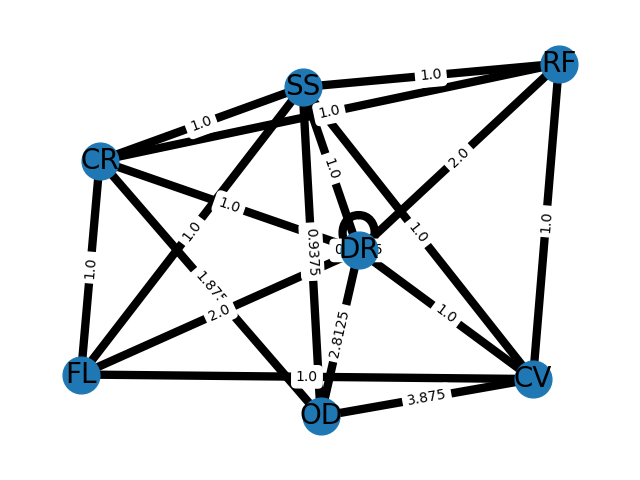

In [4]:
wW = 1- .25**2 #window-wall area
dW = 1 - .25*.75 #door-wall area
interiorRooms = ["CR", "SS", "DR", "CV"]
roomList = [*interiorRooms, "OD", "RF", "FL"]

connectivityMatrix = np.array([
    [0, 1, 1, 0, 2*wW, 1, 1],
    [1, 0, 1 ,1, wW, 1, 1],
    [1, 1, dW, 1, 3*wW, 2, 2],
    [0, 1, 1, 0, 2*wW + 2, 1, 1],
])

bG = bg.BuildingGraph(connectivityMatrix, roomList)
bG.draw()

In [5]:
sim_kwargs = {
    "delt": times[1] - times[0],
    "simLength": times[-1] - times[0],
    "Tout" : Touts,
    "radG": rad,
    "Tfloor": np.mean(Touts),
}
wall_kwargs = {"X": 4, "Y": 3, "th": 0.1}
wall_kwargs_RF = {"X": 4, "Y": 4, "th": .25}
wall_kwargs_FL = {"X": 4, "Y": 4, "th": .5}

room_kwargs = {
    "T0": Touts[0],
    "V" : 4**2 * 3, #volume of air
    "Eint" : 0 #internal heat generation
}
vent_kwargs = {
    'H': 1,
    'W' : 1,
    "ventType": None,
    "alphas": alphas,
    "As": As,
    "Ls": Ls,
}
rad_kwargs_RF = {
    "bG": bg.BuildingGraph(
        np.array([
            [0, -1, -1, -1, -1],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
        ]),
        ["sun", "SS", "DR", "CV",  "CR", ]
    ),
}

rad_kwargs_FL = {
    "bG": bg.BuildingGraph(
        np.array([
            [0, 3],
            [3, 0],
        ]),
        ["RF", "FL"]
    ),
}



In [6]:
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateEdges({"wall_kwargs" :wall_kwargs_RF}, nodes=["RF"])
bG.updateEdges({"wall_kwargs" :wall_kwargs_FL}, nodes=["FL"])
for e in [("CV", "RF"), ("CV", "FL")]:
    bG.G.edges[e]["wall_kwargs"]["X"] *= 2

bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })
bG.updateNodes({"rad_kwargs": rad_kwargs_RF}, nodes=["RF"])
bG.updateNodes({"rad_kwargs": rad_kwargs_FL}, nodes=["SS", "DR", "CV", "CR"])

for r in ["CR", "DR"]:
    bG.G.nodes[r]["room_kwargs"]["V"] *= 2

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

<Figure size 640x480 with 0 Axes>

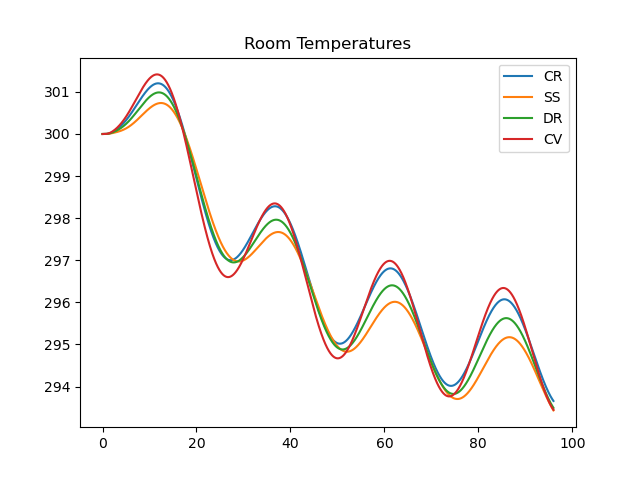

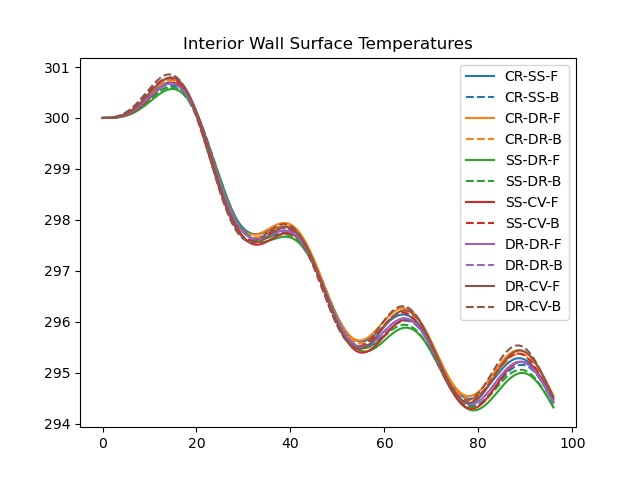

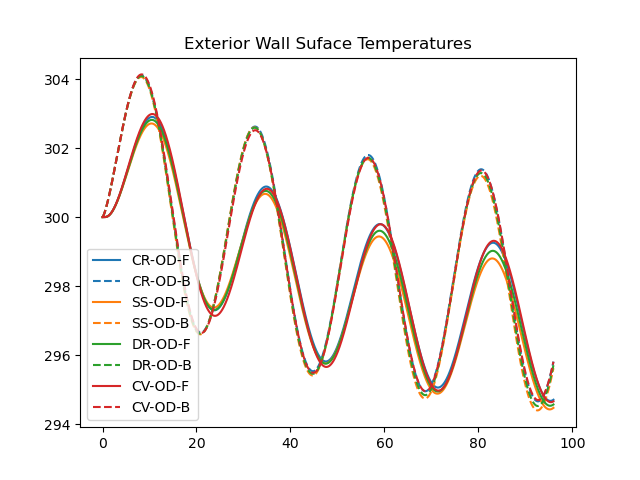

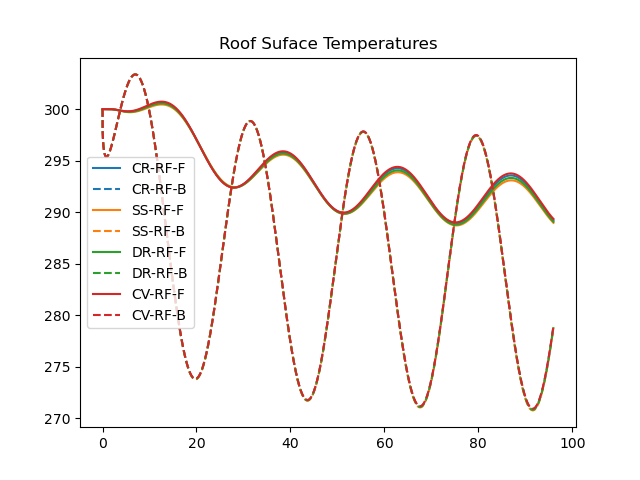

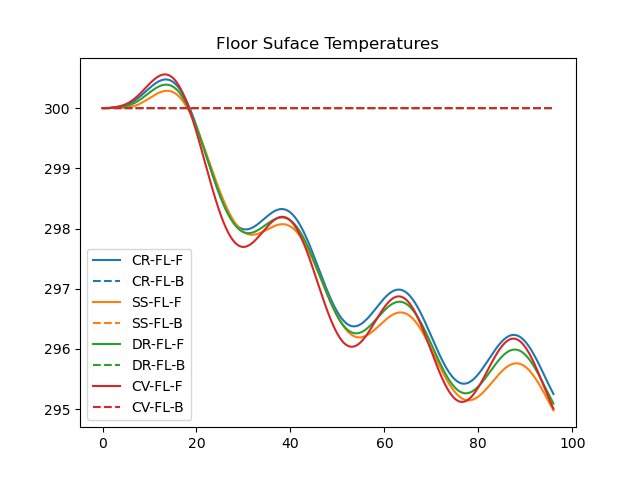

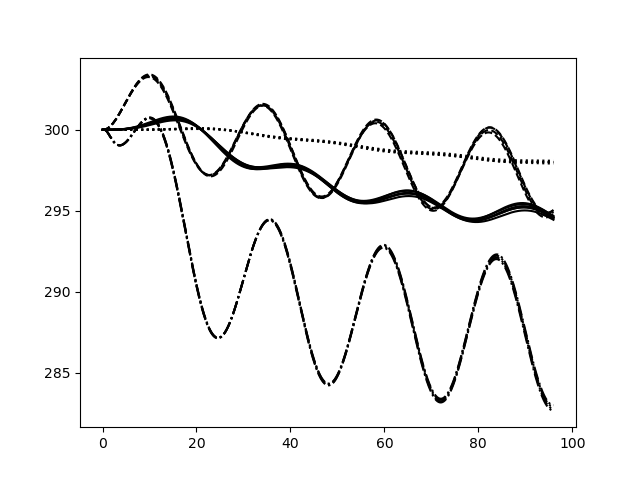

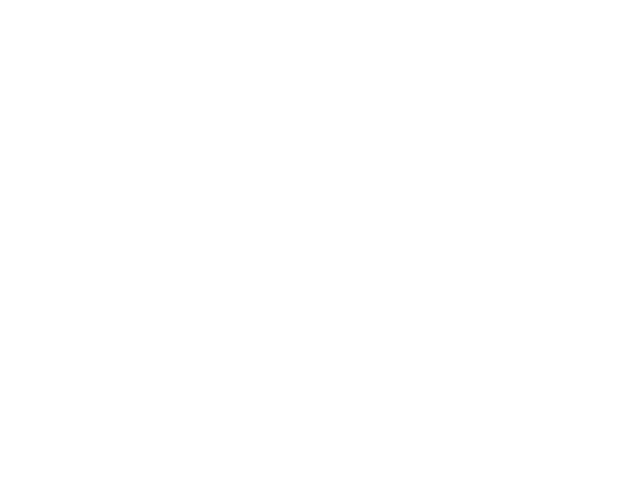

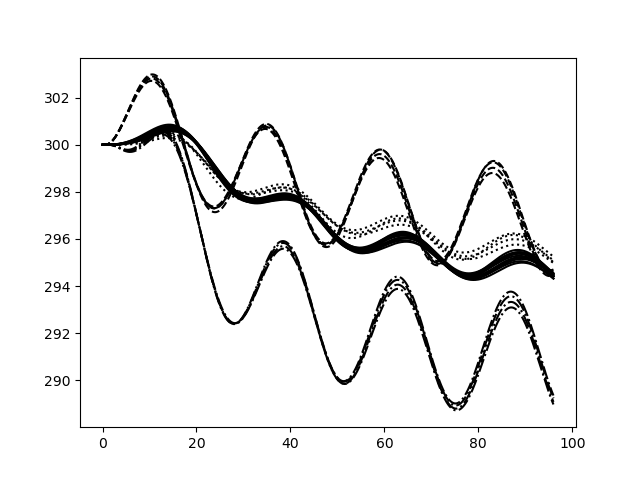

In [7]:
plt.figure()
for n, d in build_sim.bG.G.nodes(data=True):
    if n in interiorRooms:
        plt.plot(build_sim.hours, d['Tints'], label=n)
plt.legend()
plt.title("Room Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        colors = list(mcolors.TABLEAU_COLORS.keys())
        linetypes = ['-', '--']
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Interior Wall Surface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Exterior Wall Suface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "RF" or d['nodes'].checkSides(j, False) == "RF":
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Roof Suface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "FL" or d['nodes'].checkSides(j, False) == "FL":
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Floor Suface Temperatures")

plt.figure()
for i, j, d in build_sim.bG.G.edges(data=True):
    center = int(len(d['T_profs'][:, 0]) / 2)
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        lt = '-'
    elif d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        lt = '--'
    elif d['nodes'].checkSides(i, False) == "RF" or d['nodes'].checkSides(j, False) == "RF":
        lt = '-.'
    elif d['nodes'].checkSides(i, False) == "FL" or d['nodes'].checkSides(j, False) == "FL":
        lt = ':'
    plt.plot(build_sim.hours, d['T_profs'][center, :], color = 'k', linestyle = lt)
    # plt.legend()
plt.figure("Wall Center Temperatures")

plt.figure()
for i, j, d in build_sim.bG.G.edges(data=True):
    center = int(len(d['T_profs'][:, 0]) / 2)
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        lt = '-'
        plt.plot(build_sim.hours, d['T_profs'][-1, :], color = 'k', linestyle = lt)
    elif d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        lt = '--'
    elif d['nodes'].checkSides(i, False) == "RF" or d['nodes'].checkSides(j, False) == "RF":
        lt = '-.'
    elif d['nodes'].checkSides(i, False) == "FL" or d['nodes'].checkSides(j, False) == "FL":
        lt = ':'
    plt.plot(build_sim.hours, d['T_profs'][0, :], color = 'k', linestyle = lt)
    # plt.legend()
plt.figure("Wall Center Temperatures")

In [ ]:
# plt.figure()
# plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radECalc"].front, label='Calculated')
# plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radEApplied"].front, label='Applied')
# plt.plot(build_sim.hours, build_sim.bG.G.edges[('FL', 'R')]["radECalc"].front, label='Calculated')
# plt.plot(build_sim.hours, build_sim.bG.G.edges[('FL', 'R')]["radEApplied"].front, label='Applied')
# plt.legend()
# # plt.ylim([-200, 25])
# plt.xlabel('hours')
# plt.ylabel('Radiation [W]')